In [1]:
# (1) for pwr or (2) for bwr
reactor = 1

Max Fluid Temp: 336.80187159487355
Max Fuel Temp: 1733.303511765987
Max Clad Temp: 344.7357049637734


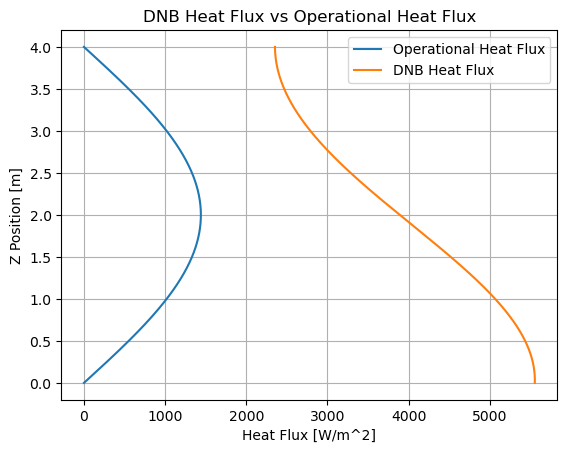

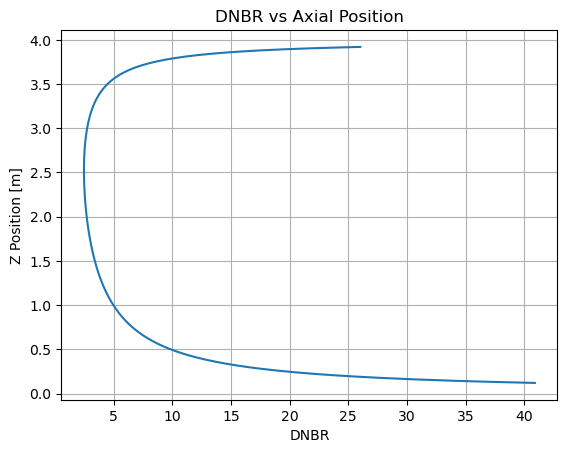

 Minimum DNBR: 2.468340028795175


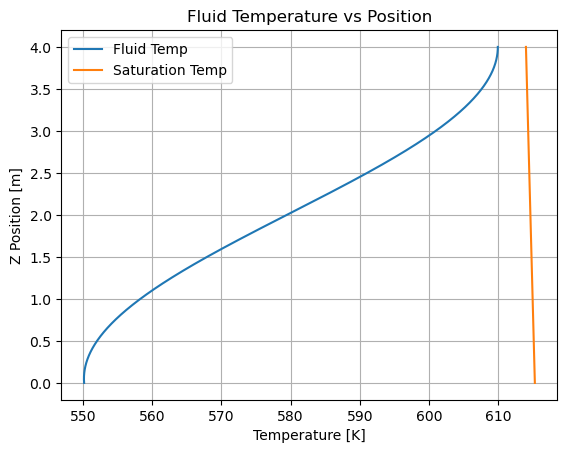

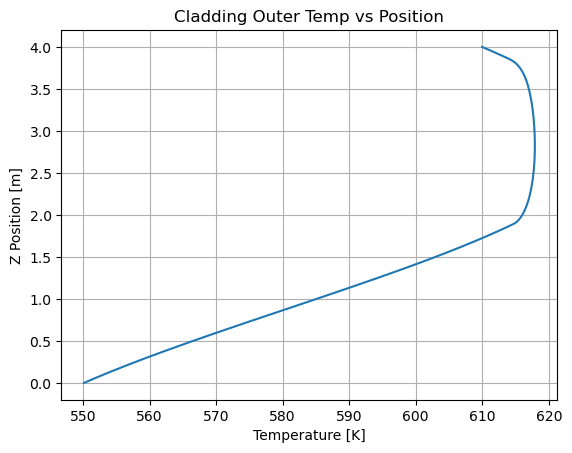

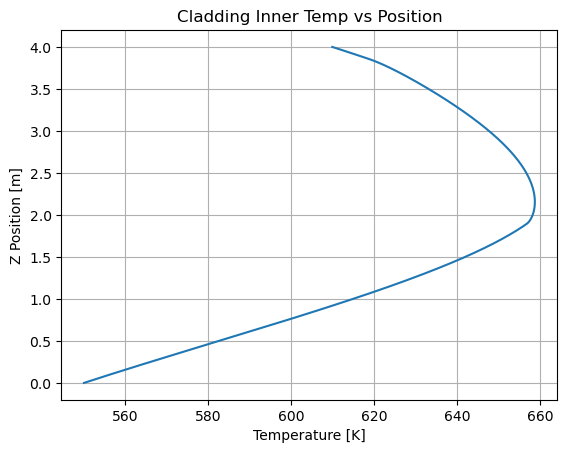

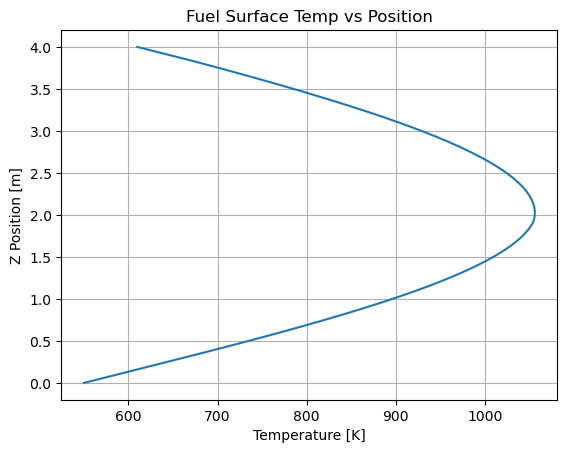

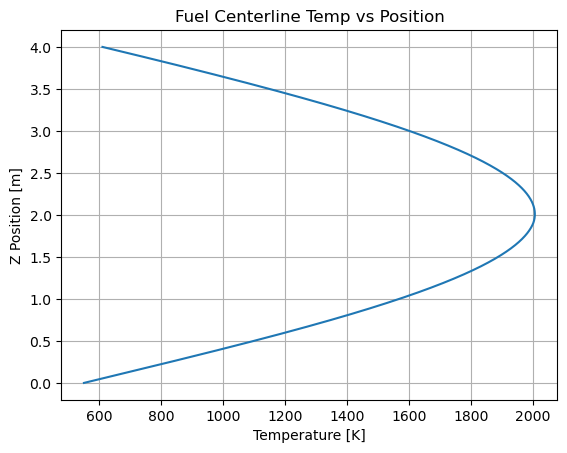

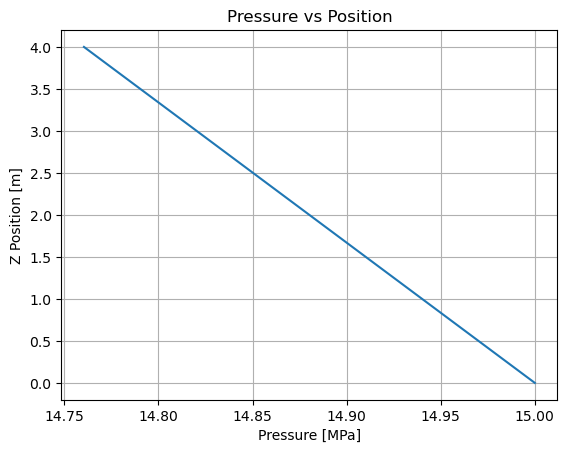

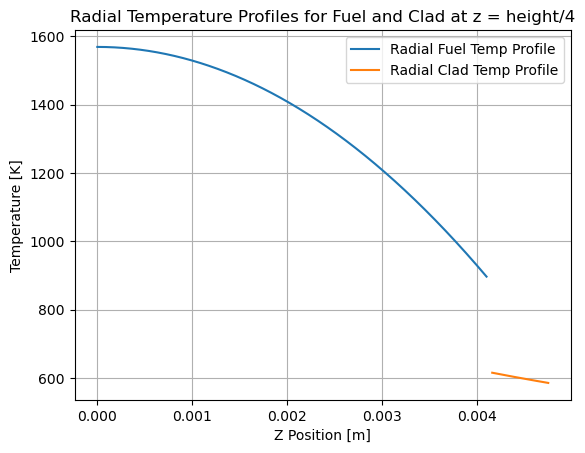

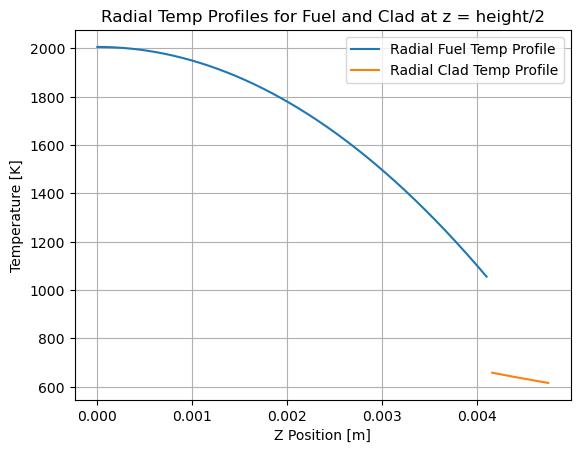

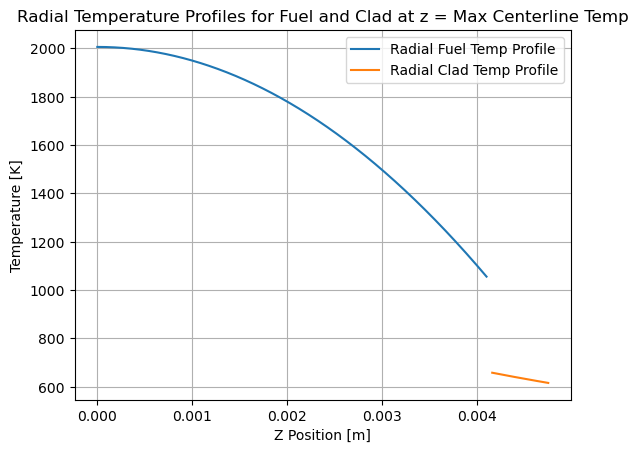

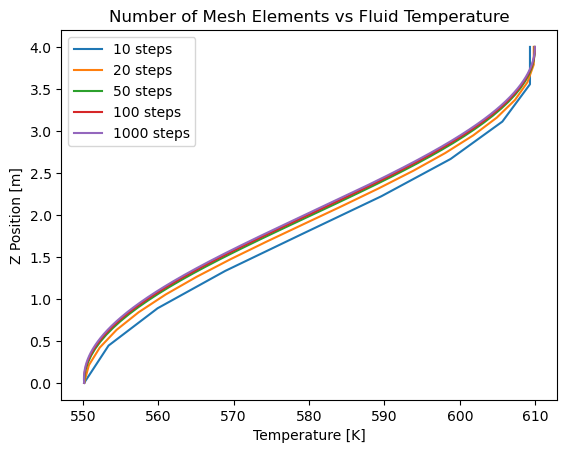

In [3]:
# imports
import numpy as np
import matplotlib.pyplot as plt
from pyXSteam.XSteam import XSteam as xs
import warnings
warnings.filterwarnings('ignore')

# givens
if reactor == 1:
    height = 4
    d_rod = 0.95 / 100
    pitch = 1.26 / 100
    d_fuel = 0.82 / 100
    gap_t = 0.006 / 100
    k_gap = 0.25
    k_fuel = 3.6
    k_clad = 21.5
    mass_flux = 4000
    qo = 430 * 100
    p_z0 = 15
    tf_z0 = 277
    tf_0 = tf_z0 + 273.15
    g = 9.81
    mu = 97.575e-6
    mu_l = 69.403e-6
    mu_v = 22.716e-6

if reactor == 2:
    height = 4.1
    d_rod = 1.227 / 100
    pitch = 1.62 / 100 
    d_fuel = 1.04 / 100 
    gap_t= 0.010 / 100
    k_gap = 0.25
    k_fuel = 3.6
    k_clad = 21.5
    mass_flux = 2350
    qo = 605 * 100
    p_z0 = 7.5
    tf_z0 = 272
    tf_0 = tf_z0 + 273.15
    g = 9.81
    mu = 97.352e-6
    mu_l = 89.451e-6
    mu_v = 11.656e-6

z = np.linspace(0, height, 1000)

# geometry
a_fluid = (pitch)**2-1/4*np.pi*d_rod**2
xi = np.pi*d_rod
d_h = 4*a_fluid/(xi)

# heat generation
def qp(x): return qo*np.sin(x * np.pi / height)
def qpp(x): return qp(x) / xi

# physical properties
st = xs(xs.UNIT_SYSTEM_BARE)
tf0,p0 = tf_0,p_z0

cp = st.Cp_pt(p0,tf0) * 1e3
k = st.tc_pt(p0,tf0)

# enthalpies
def hf(x): return st.hL_p(x) * 1e3
def hg(x): return st.hV_p(x) * 1e3
def hfg(x): return (hg(x) - hf(x))
def tsat(x): return st.tsat_p(x)

def dhfdp(x): return (7.11762e-16*(x)**2-1.85296e-8*(x)+1.52758e-1)
def dhfgdp(x): return (-7.7343e-16*(x)**2+1.65472e-8*(x)+1.4331e-1)

# initial conditions
Xe0 = cp*(tf0 - tsat(p0))/hfg(p0)
rho0 = st.rho_pt(p0,tf0)

# dimensionless groups
Re = mass_flux*d_h/mu
Pr = cp*mu/k

if Re > 10000: Nu = 0.023*Re**(0.8)*Pr**(0.4)
if Re < 2100: Nu = 4.36

h_val = Nu*k/d_h
f = Re**(-0.25)*0.316

# other properties
def pratio(x): return st.rhoV_p(x) / st.rhoL_p(x)
def alpha(x, y): return 1 / (1 + (x**(-1) - 1) * pratio(y))

rho_l = st.rhoL_p(p0)
rho_v = st.rhoV_p(p0)
rho_fg = rho_l - rho_v

# solving for the fluid
P = [p_z0*1e6]
Xe = [Xe0]
X = [0]
Tf = [tf_0]
Tsat = [tsat(p_z0)]

for i in range(1, len(z)):
    # equilibrium quality
    dz = z[i]- z[i-1]
    if Xe[i-1] <= 0:
        X[i-1] = 0
    elif Xe[i-1] < 1:
        X[i-1] = Xe[i-1]

    # properties
    nu_l = st.vL_p(p_z0)
    nu_g = st.vV_p(p_z0)
    nu_fg = nu_g-nu_l
    rho_m = 1/(nu_l+X[i-1]*(nu_fg))

    # new pressure
    if Xe[i-1]<=0:
        dP = g / nu_l + f * mass_flux**2 * nu_l * xi / 2 / a_fluid
    elif Xe[i-1] < 1:
        mum = 1/(Xe[i-1]/mu_v + (1-Xe[i-1])/mu_l)
        f_val = 0.046*Re**(-0.2)*(mu_l/mum)**(-0.2)
        tP_1 = 1/2*xi/a_fluid*f_val*mass_flux**2*(nu_l+X[i-1]*(nu_fg))
        tP_2 = rho_m*g
        tP_3 = mass_flux*qp(z[i])*(nu_g-nu_l)/(a_fluid*hfg(P[i-1]*1e-6))
        bP_1 = dhfdp(P[i-1])+Xe[i-1]*dhfgdp(P[i-1])
        bP_2 = 1-mass_flux**2*(nu_g-nu_l)/(hfg(P[i-1]*1e-6))*bP_1
        dP = (tP_1+tP_2+tP_3)/bP_2
    P_i = P[i-1]-dz*dP
    dpdz = (P_i-P[i-1])/dz

    # new quality
    iXe_1 = dhfdp(P[i-1])*dpdz+Xe[i-1]*dhfgdp(P[i-1])*dpdz
    iXe_2 = qp(z[i])/(a_fluid*mass_flux*hfg(P_i*1e-6))-1/hfg(P_i*1e-6)*iXe_1
    Xei = dz*iXe_2+Xe[i-1]

    # fluid temp
    if Xei <= 0:
        Tfi = hfg(P_i*1e-6)/cp*Xei+tsat(P_i*1e-6)
    else:
        Tfi = tsat(P_i*1e-6)

    Tsat.append(tsat(P_i*1e-6))
    P.append(P_i)
    Xe.append(Xei)
    X.append(X)
    Tf.append(Tfi)

# steam quality
Xe_ar = np.array(Xe)
X_ar = np.zeros(z.size)
for i in range(len(z)):
    if Xe_ar[i] < 0:
        X_ar[i] = 1e-12
    else:
        X_ar[i] = Xe_ar[i]

# surface temp
q_p = qo*np.sin(z*np.pi/height)
Tsat_ = []
for i in P:
    Tsat_.append(tsat(i*1e-6))
tsat_ar = np.array(Tsat_)
tw = np.zeros(z.size)
P_ar = np.array(P)*1e-6
z_ar = np.array(z)
tsat_ar = np.array(Tsat_)
tf_ar = np.array(Tf)
twall = np.zeros(z.size)
for i in range(z.size):
    twall = q_p[i]/(xi*h_val)+tf_ar[i]
    if (twall<=tsat_ar[i]):
        tw[i] = twall
    else:
        F=(1+X_ar[i]*Pr*(rho_l/rho_v - 1))**(0.35)
        S = 1/(1+0.055*F**0.1*Re**0.16)
        qpp = q_p[i]/xi
        prat = P_ar[i]/22.064
        hNB = 55*(prat)**0.12*18**(-0.5)*qpp**(2/3)*(-np.log10(prat))**(-0.55)

        # quad eq coeffs
        c = -qpp**2+F**2*h_val**2*tf_ar[i]**2+S**2*hNB**2*tsat_ar[i]**2
        a = F**2*h_val**2+S**2*hNB**2
        b = -2*(F**2*h_val**2*tf_ar[i]+S**2*hNB**2*tsat_ar[i])

        deter = b**2-4*a*c
        tw[i] = (-b+np.sqrt(deter))/(2*a)

# geometry
r_fuel = d_fuel /2
r_cladi = d_fuel /2 + gap_t
r_clado = d_rod / 2
clad_inner_area = 2*r_cladi * np.pi
area_fuel = r_fuel**2 * np.pi

C1 = 0
C3 = -k_fuel/k_gap*(qp(z)*(r_fuel)**2/(2*k_fuel*area_fuel))
C5 = k_gap/k_clad*C3
C6 = tw - C5*np.log(r_clado)
C4 = C5*np.log(r_cladi)-C3*np.log(r_cladi)+C6
C2 = C3*np.log(r_fuel)+C4+qp(z)*(r_fuel)**2/(4*k_fuel*area_fuel)

def T_fuel(x): return -qp(z)*x**2/(4*k_fuel*area_fuel)+C2
def T_gap(x): return C3*np.log(x)+C4
def T_clad(x): return C5*np.log(x)+C6

tck = np.zeros(z.size)
for i in range(z.size):
    tck[i] = 273.15
tw_c = tw-tck

# locations of max temps
print(f'Max Fluid Temp: {max(Tf) - 273.15}')
print(f'Max Fuel Temp: {max(T_fuel(0)) - 273.15}')
print(f'Max Clad Temp: {max(T_clad(r_clado)) - 273.15}')

# CHF, DNB, and CPR
# solving for unknowns
Xe_abs = [abs(x) for x in Xe]
Xe_abs = np.array(Xe_abs)

hin = []
for i in range(len(z)):
    hin.append(hf(p0))
hin_ar = np.array(hin)*1e-3
hf_ = []
for i in P_ar:
    hf_.append(hf(i))
hf_ar = np.array(hf_)*1e-3

# chf using W-3 correlation
part1 = (2.022-0.06238*P_ar)+(0.1722-0.01427*P_ar)*np.exp((18.177-0.5987*P_ar)*Xe_ar)
part2 = (0.1484-1.596*Xe_ar+0.1729*Xe_ar*Xe_abs)*2.326*mass_flux+3271
part3 = 1.157-0.869*Xe_ar
part4 = 0.2664+0.8357*np.exp(-124.1*d_h)
part5 = 0.8258+0.0003413*(hf_ar-hin_ar)
qcr_DNB = part1 * part2 * part3 * part4 * part5

# BWR dryout
if reactor == 2:
    hfg_ = []
    for i in P_ar:
        hfg_.append(hfg(i))
    hfg_ar = np.array(hfg_)
    Pr_ar = []
    for i in P:
        Pr_ar.append(0.145*i*1e-6)
    Pr_ar = np.array(Pr_ar)
    if min(Pr_ar) < 1:
        F1 = (Pr_ar**18.942*np.exp(20.89*(1-Pr_ar))+0.917)/1.917
        F2 = F1/((Pr_ar**1.316*np.exp(2.444*(1-Pr_ar))+0.309)/1.309)
        F3 = (Pr_ar**17.023*np.exp(16.658*(1-Pr_ar))+0.667)/1.667
        F4 = F3*Pr_ar**1.649
    if min(Pr_ar) > 1:
        F1 = Pr_ar**(-0.368)*np.exp(0.648*(1-Pr_ar))
        F2 = F1/(Pr_ar**(-0.448)*np.exp(0.245*(1-Pr_ar)))
        F3 = Pr_ar**0.219
        F4 = F3*Pr_ar**1.649
    n = 2.0-0.5*Pr_ar
    A = 2.317*(hfg_ar*d_rod*mass_flux/4)*F1
    B = d_rod*mass_flux/4
    C = 0.077*F3*d_rod*mass_flux/(1+0.347*F4*(mass_flux/1356)**n)
    q_cr_dryout = (A-B*hfg_ar*X_ar)/C

if reactor == 1:
    plt.plot(qp(z)*1e-3/xi,z,label = 'Operational Heat Flux')
    plt.plot(qcr_DNB,z,label = 'DNB Heat Flux')
    plt.xlabel('Heat Flux [W/m^2]'), plt.ylabel('Z Position [m]')
    plt.grid(), plt.legend()
    plt.title('DNB Heat Flux vs Operational Heat Flux')
    plt.show()

    DNBR = qcr_DNB/(qp(z)*1e-3/xi)
    plt.plot(DNBR[30:980],z[30:980])
    plt.xlabel('DNBR'), plt.ylabel('Z Position [m]')
    plt.grid()
    plt.title('DNBR vs Axial Position')
    plt.show()
    print(f" Minimum DNBR: {min(qcr_DNB/(qp(z)*1e-3/xi))}")

if reactor == 2:
    plt.plot(qp(z)*1e-3/xi,z,label = 'Operational Heat Flux')
    plt.plot(qcr_DNB, z, label = 'DNB Heat Flux')
    plt.xlabel('Heat Flux [W/m^2]'), plt.ylabel('Z Position [m]')
    plt.grid()
    plt.title('DNB Heat Flux vs Operational Heat Flux')
    plt.legend()
    plt.show()

    DNBR = qcr_DNB/(qp(z)*1e-3/xi)
    plt.plot(DNBR[30:980],z[30:980])
    plt.xlabel('DNBR'), plt.ylabel('Z Position [m]')
    plt.grid()
    plt.title('DNBR vs Axial Position')
    plt.show()
    print(f"Min DNBR: {min(qcr_DNB/(qp(z)*1e-3/xi))}")

# cpr
def q_multi(n):
    height = 4.1
    d_rod = 1.227 / 100
    pitch = 1.62 / 100 
    d_fuel = 1.04 / 100 
    gap_t= 0.010 / 100
    k_gap = 0.25
    k_fuel = 3.6
    k_clad = 21.5
    mass_flux = 2350
    qo = n * 605 * 100
    p_z0 = 7.5
    tf_z0 = 272
    tf_0 = tf_z0 + 273.15
    g = 9.81
    mu = 97.352e-6
    mu_l = 89.451e-6
    mu_v = 11.656e-6
    
    z = np.linspace(0,height,1000)

    # solving for the fluid
    P = [p_z0*1e6]
    Xe = [Xe0]
    X = [0]
    Tf = [tf_0]
    Tsat = [tsat(p_z0)]
    for i in range(1, len(z)):
        # pressure
        dz = z[i]- z[i-1]
        if Xe[i-1] <= 0:
            X[i-1] = 0
        elif Xe[i-1] < 1:
            X[i-1] = Xe[i-1]
        nu_l = st.vL_p(p_z0)
        nu_g = st.vV_p(p_z0)
        nu_fg = nu_g-nu_l
        rho_m = 1/(nu_l+X[i-1]*(nu_fg))

        if Xe[i-1]<=0:
            dP = (g/nu_l+f*mass_flux**2*nu_l*xi/(2*a_fluid))
        elif Xe[i-1] < 1:
            mum = 1/(Xe[i-1]/mu_v + (1-Xe[i-1])/mu_l)
            f_val = 0.046*Re**(-0.2)*(mu_l/mum)**(-0.2)
            tP_1 = 1/2*xi/a_fluid*f_val*mass_flux**2*(nu_l+X[i-1]*(nu_fg))
            tP_2 = rho_m*g
            tP_3 = mass_flux*qp(z[i])*(nu_g-nu_l)/(a_fluid*hfg(P[i-1]*1e-6))
            bP_1 = dhfdp(P[i-1])+Xe[i-1]*dhfgdp(P[i-1])
            bP_2 = 1-mass_flux**2*(nu_g-nu_l)/(hfg(P[i-1]*1e-6))*bP_1
            dP = (tP_1+tP_2+tP_3)/bP_2
        P_i = P[i-1]-dz*dP
        dpdz = (P_i-P[i-1])/dz
        # new quality
        iXe_1 = dhfdp(P[i-1])*dpdz+Xe[i-1]*dhfgdp(P[i-1])*dpdz
        iXe_2 = qp(z[i])/(a_fluid*mass_flux*hfg(P_i*1e-6))-1/hfg(P_i*1e-6)*iXe_1
        Xei = dz*iXe_2+Xe[i-1]

        # fluid temp
        if Xei < 0: Tfi = hfg(P_i*1e-6)/cp*Xei+tsat(P_i*1e-6)
        else: Tfi = tsat(P_i*1e-6)

        Tsat.append(tsat(P_i*1e-6))    
        P.append(P_i)
        Xe.append(Xei)
        X.append(X)
        Tf.append(Tfi)

    # steam quality
    Xe_ar = np.array(Xe)
    X_ar = np.zeros(z.size)
    for i in range(len(z)):
        if Xe_ar[i] < 0:
            X_ar[i] = 1e-12
        else:
            X_ar[i] = Xe_ar[i]

    # surface temp
    q_p = qo*np.sin(z*np.pi/height)
    Tsat_ = []
    for i in P:
        Tsat_.append(tsat(i*1e-6))
    tsat_ar = np.array(Tsat_)
    tw = np.zeros(z.size)
    P_ar = np.array(P)*1e-6
    z_ar = np.array(z)
    tsat_ar = np.array(Tsat_)
    tf_ar = np.array(Tf)
    twall = np.zeros(z.size)
    for i in range(z.size):
        twall = q_p[i]/(xi*h_val)+tf_ar[i]
        if (twall<=tsat_ar[i]):
            tw[i] = twall
        else:
            print(X_ar[i], Pr, rho_l, rho_v)
            F = (1 + X_ar[i] * Pr * (rho_l/rho_v - 1))**(0.35)
            S = 1/(1+0.055*F**0.1*Re**0.16)
            qpp = q_p[i]/xi
            prat = P_ar[i]/22.064
            hNB = 55*(prat)**0.12*18**(-0.5)*qpp**(2/3)*(-np.log10(prat))**(-0.55)

            # quadratic eq coeffs
            c = -qpp**2+F**2*h_val**2*tf_ar[i]**2+S**2*hNB**2*tsat_ar[i]**2
            a = F**2*h_val**2+S**2*hNB**2
            b = -2*(F**2*h_val**2*tf_ar[i]+S**2*hNB**2*tsat_ar[i])

            deter = b**2-4*a*c
            tw[i] = (-b+np.sqrt(deter))/(2*a)

    tck = np.zeros(z.size)
    for i in range(z.size):
        tck[i] = 273.15
    return np.array(Xe),z,np.array(P)*1e-6

# finding CPR
if reactor == 2:
    Q1,z1,P1 = q_multi(1.17)
    Q2,z2,P2 = q_multi(1.75)
    Q3,z3,P3 = q_multi(2.28)
    Q4,z4,P4 = q_multi(2.5)
    Q5,z5,P5 = q_multi(2.71)

    Di = d_rod
    Ds = (Di*d_h+Di**2)**(1/2)
    De = Ds-Di
    def XCR_finder(Xe_ar,z,P_ar):
        i = 0
        while Xe_ar[i] < 0:
            i+=1
        z_boil = z[i]
        Xe_ar = Xe_ar[i:]
        lb = z[i:]-z_boil*np.ones(z[i:].size)
        a = (1-P_ar[i:]/22)/(mass_flux/1000)**(1/3)
        b = 0.199*(22/P_ar[i:]-1)**(0.4)*mass_flux*d_h**(1.4)
        xc = d_h/De*(a*(lb/(lb+b)))
        return xc,lb,Xe_ar

    xc1,lb1,Xe1 = XCR_finder(Q1,z1,P1)
    xc2,lb2,Xe2 = XCR_finder(Q2,z2,P2)
    xc3,lb3,Xe3 = XCR_finder(Q3,z3,P3)
    xc4,lb4,Xe4 = XCR_finder(Q4,z4,P4)
    xc5,lb5,Xe5 = XCR_finder(Q5,z5,P5)
    plt.plot(lb1,Xe1,label = 'Q1')
    plt.plot(lb2,Xe2,label = 'Q2')
    plt.plot(lb3,Xe3,label = 'Q3')
    plt.plot(lb4,Xe4,label = 'Q4')
    plt.plot(lb5,Xe5,label = 'Q5')
    plt.plot(lb5,xc5,label = 'critical quality')
    plt.xlabel('Boiling Length [m]')
    plt.ylabel('Quality')
    plt.legend()
    plt.grid()

# BWR plots
if reactor == 2:
    al = []
    for i in X_ar:
        al.append(alpha(i,p0))

    #density
    Xe_arr = np.array(Xe)
    dens = []
    for i in range(len(Xe)):
        if Xe_arr[i] < 0:
            dens.append(rho_l)
        if Xe_arr[i]>0:
            dens.append((1/rho_l+1/rho_fg*X_ar[i])**(-1))

    # ONB location
    for index,(value1,value2) in enumerate(zip(tw,tsat_ar)):
        if value1 >= value2:
            print(f"Value {value1} at index {index} in array 1 is greater than {value2} at index {index} in array 2")
            break 
    z_ONB = z[index]
    print(z_ONB) #[m]

    # sat boiling
    for index_,(val1,val2) in enumerate(zip(tf_ar,tsat_ar)):
        if val1 >= val2:
            print(f"Value {val1} at index {index_} in array 1 is greater than {val2} at index {index_} in array 2")
            break
    z_SATBOIL = z[index_]
    print(z_SATBOIL)

P_ = np.array(P)
P_=P_/1e6
pal = list(P_)

if reactor == 1:
    # bulk temp
    plt.plot(Tf,z,label='Fluid Temp')
    plt.plot(Tsat_,z,label='Saturation Temp')
    plt.xlabel('Temperature [K]'), plt.ylabel('Z Position [m]')
    plt.legend()
    plt.grid()
    plt.title('Fluid Temperature vs Position')
    plt.show()

    # t_c0
    plt.plot(tw,z)
    plt.xlabel('Temperature [K]')
    plt.ylabel('Z Position [m]')
    plt.grid()
#    plt.savefig('plots/tco-pwr.png', dpi=600)
    plt.title('Cladding Outer Temp vs Position')
    plt.show()

    # t_ci
    plt.plot(T_clad(r_cladi),z)
    plt.xlabel('Temperature [K]'), plt.ylabel('Z Position [m]')
    plt.grid(), plt.title('Cladding Inner Temp vs Position')
    plt.show()

    # t_f0
    plt.plot(T_fuel(r_fuel),z)
    plt.xlabel('Temperature [K]'), plt.ylabel('Z Position [m]')
    plt.grid(), plt.title('Fuel Surface Temp vs Position')
    plt.show()

    # t_cl
    plt.plot(T_fuel(0),z)
    plt.xlabel('Temperature [K]'), plt.ylabel('Z Position [m]')
    plt.grid(), plt.title('Fuel Centerline Temp vs Position')
    plt.show()

    # pressure 
    plt.plot(pal,z)
    plt.xlabel('Pressure [MPa]'), plt.ylabel('Z Position [m]')
    plt.grid(), plt.title('Pressure vs Position')
    plt.show()

if reactor == 2:
    # bulk temperature
    plt.plot(Tf,z,label='Mean Fluid Temp')
    plt.plot(Tsat_,z,label='Saturation Temp')
    plt.xlabel('Temperature [K]')
    plt.ylabel('Z Position [m]')
    plt.axhline(z_ONB,label = 'ONB Location',color = 'black', ls='--')
    plt.axhline(z_SATBOIL,label = 'Saturation Boiling Location',color = 'black', ls='--')
    plt.legend(), plt.grid(), plt.title('Temperature vs Position')
    plt.show()

    # t_c0
    plt.plot(tw,z)
    plt.xlabel('Temperature [K]'), plt.ylabel('Z Position [m]')
    plt.axhline(z_ONB,label = 'ONB Location',color = 'black', ls='--')
    plt.axhline(z_SATBOIL,label = 'Saturation Boiling Location',color = 'black', ls='--')
    plt.legend(), plt.grid(), plt.title('Clad Outer Temp vs Position')
    plt.show()

    # t_ci
    plt.plot(T_clad(r_cladi),z)
    plt.xlabel('Temperature [K]'), plt.ylabel('Z Position [m]')
    plt.grid(), plt.title('Clad Inner Temp vs Position')
    plt.show()

    # outer fuel temp
    plt.plot(T_fuel(r_fuel),z)
    plt.xlabel('Temperature [K]'), plt.ylabel('Z Position [m]')
    plt.grid(), plt.title('Fuel Surface Temp vs Position')
    plt.show()

    # tcl
    plt.plot(T_fuel(0),z)
    plt.xlabel('Temperature [K]'), plt.ylabel('Z Position [m]')
    plt.grid(), plt.title('Fuel Centerline/Max Temp vs Position')
    plt.show()

    # pressure 
    plt.plot(pal,z)
    plt.xlabel('Pressure [MPa]'), plt.ylabel('Z Position [m]')
    plt.grid(), plt.title('Pressure vs Position')
    plt.show()

    # density
    plt.plot(dens,z)
    plt.xlabel('Density in [kg/m^3]'), plt.ylabel('Z Position [m]')
    plt.grid(), plt.title('Density vs Position')
    plt.show()

    # quality
    plt.plot(list(X_ar),z)
    plt.xlabel('Quality and Critical Quality'), plt.ylabel('Z Position [m]')
    plt.grid(), plt.title('Quality vs Position')
    plt.show()
    
    #void fraction
    plt.plot(al,z)
    plt.xlabel('Void fraction'), plt.ylabel('Z Position [m]')
    plt.grid(), plt.title('Void Fraction vs Position')
    plt.show()

# max cl temp
max_index_CL = T_fuel(0).argmax()
z_location = z[max_index_CL]

index_height_4 = 250
index_height_2 = 500

#defining for height/4
C1 = 0
C3 = -k_fuel/k_gap*(qp(z[250])*(r_fuel)**2/(2*k_fuel*area_fuel))
C5 = k_gap/k_clad*C3
C6 = tw[250] - C5*np.log(r_clado)
C4 = C5*np.log(r_cladi)-C3*np.log(r_cladi)+C6
C2 = C3*np.log(r_fuel)+C4+qp(z[250])*(r_fuel)**2/(4*k_fuel*area_fuel)
def T_fuel(x):
    T_fuel = -qp(z[250])*x**2/(4*k_fuel*area_fuel)+C2
    return T_fuel

def T_gap(x):
    T_gap = C3*np.log(x)+C4
    return T_gap

def T_clad(x):
    T_clad = C5*np.log(x)+C6
    return T_clad

rad_f = np.linspace(0,r_fuel,1000)
rad_c = np.linspace(r_cladi,r_clado,1000)
plt.plot(rad_f,T_fuel(rad_f),label = 'Radial Fuel Temp Profile')
plt.plot(rad_c,T_clad(rad_c),label = 'Radial Clad Temp Profile')
plt.ylabel('Temperature [K]'), plt.xlabel('Z Position [m]')
plt.legend(), plt.grid('both')
plt.title('Radial Temperature Profiles for Fuel and Clad at z = height/4')
plt.show()

#defining for height/2
C1 = 0
C3 = -k_fuel/k_gap*(qp(z[500])*(r_fuel)**2/(2*k_fuel*area_fuel))
C5 = k_gap/k_clad*C3
C6 = tw[500] - C5*np.log(r_clado)
C4 = C5*np.log(r_cladi)-C3*np.log(r_cladi)+C6
C2 = C3*np.log(r_fuel)+C4+qp(z[500])*(r_fuel)**2/(4*k_fuel*area_fuel)
def T_fuel(x):
    T_fuel = -qp(z[500])*x**2/(4*k_fuel*area_fuel)+C2
    return T_fuel

def T_gap(x):
    T_gap = C3*np.log(x)+C4
    return T_gap

def T_clad(x):
    T_clad = C5*np.log(x)+C6
    return T_clad

rad_f = np.linspace(0,r_fuel,1000)
rad_c = np.linspace(r_cladi,r_clado,1000)
plt.plot(rad_f,T_fuel(rad_f),label = 'Radial Fuel Temp Profile')
plt.plot(rad_c,T_clad(rad_c),label = 'Radial Clad Temp Profile')
plt.ylabel('Temperature [K]'), plt.xlabel('Z Position [m]')
plt.legend(), plt.grid(), plt.title('Radial Temp Profiles for Fuel and Clad at z = height/2')
plt.show()

#defining for z centerline
C1 = 0
C3 = -k_fuel/k_gap*(qp(z[max_index_CL])*(r_fuel)**2/(2*k_fuel*area_fuel))
C5 = k_gap/k_clad*C3
C6 = tw[max_index_CL] - C5*np.log(r_clado)
C4 = C5*np.log(r_cladi)-C3*np.log(r_cladi)+C6
C2 = C3*np.log(r_fuel)+C4+qp(z[max_index_CL])*(r_fuel)**2/(4*k_fuel*area_fuel)
def T_fuel(x):
    T_fuel = -qp(z[max_index_CL])*x**2/(4*k_fuel*area_fuel)+C2
    return T_fuel

def T_gap(x):
    T_gap = C3*np.log(x)+C4
    return T_gap

def T_clad(x):
    T_clad = C5*np.log(x)+C6
    return T_clad

rad_f = np.linspace(0,r_fuel,1000)
rad_c = np.linspace(r_cladi,r_clado,1000)
plt.plot(rad_f,T_fuel(rad_f),label = 'Radial Fuel Temp Profile')
plt.plot(rad_c,T_clad(rad_c),label = 'Radial Clad Temp Profile')
plt.ylabel('Temperature [K]')
plt.xlabel('Z Position [m]')
plt.legend()
plt.grid()
#plt.savefig('plots2/pwr-max.png', dpi=600)
plt.title('Radial Temperature Profiles for Fuel and Clad at z = Max Centerline Temp')
plt.show()


# mesh spacing
def CP_func(N):    
    z = np.linspace(0, height, N)
    
    P = [p_z0*1e6]
    Xe = [Xe0]
    X = [0]
    Tf = [tf_0]
    Tsat = [tsat(p_z0)]
    for i in range(1, len(z)):
        #FINDINmass_flux PRESSURE
        dz = z[i]- z[i-1]
        if Xe[i-1] <= 0:
            X[i-1] = 0
        elif Xe[i-1] < 1:
            X[i-1] = Xe[i-1]
        nu_l = st.vL_p(p_z0)
        nu_g = st.vV_p(p_z0)
        nu_fg = nu_g-nu_l
        rho_m = 1/(nu_l+X[i-1]*(nu_fg))
    
        if Xe[i-1]<=0:
            dP = (g/nu_l+f*mass_flux**2*nu_l*xi/(2*a_fluid))
        elif Xe[i-1] < 1:
            mum = 1/(Xe[i-1]/mu_v + (1-Xe[i-1])/mu_l)
            f_val = 0.046*Re**(-0.2)*(mu_l/mum)**(-0.2)
            tP_1 = 1/2*xi/a_fluid*f_val*mass_flux**2*(nu_l+X[i-1]*(nu_fg))
            tP_2 = rho_m*g
            tP_3 = mass_flux*qp(z[i])*(nu_g-nu_l)/(a_fluid*hfg(P[i-1]*1e-6))
            bP_1 = dhfdp(P[i-1])+Xe[i-1]*dhfgdp(P[i-1])
            bP_2 = 1-mass_flux**2*(nu_g-nu_l)/(hfg(P[i-1]*1e-6))*bP_1
            dP = (tP_1+tP_2+tP_3)/bP_2
        P_i = P[i-1]-dz*dP
        dpdz = (P_i-P[i-1])/dz
        #FINDINmass_flux QUALITY NOW
        iXe_1 = dhfdp(P[i-1])*dpdz+Xe[i-1]*dhfgdp(P[i-1])*dpdz
        iXe_2 = qp(z[i])/(a_fluid*mass_flux*hfg(P_i*1e-6))-1/hfg(P_i*1e-6)*iXe_1
        Xei = dz*iXe_2+Xe[i-1]
    
        #FINDINmass_flux FLUID TEMPERATURE NOW
        if Xei < 0:
            Tfi = hfg(P_i*1e-6)/cp*Xei+tsat(P_i*1e-6)
        else:
            Tfi = tsat(P_i*1e-6)
            
        Tsat.append(tsat(P_i*1e-6))    
        P.append(P_i)
        Xe.append(Xei)
        X.append(X)
        Tf.append(Tfi)
    
    #FINDINmass_flux STEAM QUALITY
    Xe_ar = np.array(Xe)
    X_ar = np.zeros(z.size)
    for i in range(len(z)):
        if Xe_ar[i] < 0:
            X_ar[i] = 1e-12
        else:
            X_ar[i] = Xe_ar[i]
            
    #FINDINmass_flux SURFACE TEMPERATURE
    q_p = qo*np.sin(z*np.pi/height)
    Tsat_ = []
    for i in P:
        Tsat_.append(tsat(i*1e-6))
    tsat_ar = np.array(Tsat_)
    tw = np.zeros(z.size)
    P_ar = np.array(P)*1e-6
    z_ar = np.array(z)
    tsat_ar = np.array(Tsat_)
    tf_ar = np.array(Tf)
    twall = np.zeros(z.size)
    for i in range(z.size):
        twall = q_p[i]/(xi*h_val)+tf_ar[i]
        if (twall<=tsat_ar[i]):
            tw[i] = twall
        else:
            F=(1+X_ar[i]*Pr*(rho_l/rho_v - 1))**(0.35)
            S = 1/(1+0.055*F**0.1*Re**0.16)
            qpp = q_p[i]/xi
            prat = P_ar[i]/22.064
            hNB = 55*(prat)**0.12*18**(-0.5)*qpp**(2/3)*(-np.log10(prat))**(-0.55)
            
            #coefficients for quad eq
            c = -qpp**2+F**2*h_val**2*tf_ar[i]**2+S**2*hNB**2*tsat_ar[i]**2
            a = F**2*h_val**2+S**2*hNB**2
            b = -2*(F**2*h_val**2*tf_ar[i]+S**2*hNB**2*tsat_ar[i])
    
            deter = b**2-4*a*c
            tw[i] = (-b+np.sqrt(deter))/(2*a)
            
    #fuel integration constants
    C1 = 0
    C3 = -k_fuel/k_gap*(qp(z)*(r_fuel)**2/(2*k_fuel*area_fuel))
    C5 = k_gap/k_clad*C3
    C6 = tw - C5*np.log(r_clado)
    C4 = C5*np.log(r_cladi)-C3*np.log(r_cladi)+C6
    C2 = C3*np.log(r_fuel)+C4+qp(z)*(r_fuel)**2/(4*k_fuel*area_fuel)
    
    def T_fuel(x):
        T_fuel = -qp(z)*x**2/(4*k_fuel*area_fuel)+C1*x+C2
        return T_fuel
    
    def T_gap(x):
        T_gap = C3*np.log(x)+C4
        return T_gap
    
    def T_clad(x):
        T_clad = C5*np.log(x)+C5
        return T_clad
    
    tck = np.zeros(z.size)
    for i in range(z.size):
        tck[i] = 273.15
    return Tsat, P, Xe, X, Tf, tw, T_fuel, T_gap, T_clad,z

tf10 = CP_func(10)[4]
z10 = CP_func(10)[9]
tf20 = CP_func(20)[4]
z20 = CP_func(20)[9]
tf50 = CP_func(50)[4]
z50 = CP_func(50)[9]
tf100 = CP_func(100)[4]
z100 = CP_func(100)[9]
tf1000 = CP_func(1000)[4]
z1000 = CP_func(1000)[9]
plt.plot(tf10,z10,label = '10 steps')
plt.plot(tf20,z20,label = '20 steps')
plt.plot(tf50,z50,label = '50 steps')
plt.plot(tf100,z100,label = '100 steps')
plt.plot(tf1000,z1000,label = '1000 steps')
plt.xlabel('Temperature [K]')
plt.ylabel('Z Position [m]')
plt.legend()
plt.grid('both')
plt.title('Number of Mesh Elements vs Fluid Temperature')
plt.grid()
